### ESBM for recommender systems

LAST FULL FUN 23/04 9:20

In [125]:
#!uv pip install -q --system numba-cuda==0.4.0

In [126]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from collections import Counter
from collections import OrderedDict
from scipy.special import gamma
import scipy.special as sc
import numba as nb
from scipy.special import gammaln
import time
import seaborn as sns
from math import lgamma
from numba import cuda
from scipy.stats import mode
from functs import *
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix

In [127]:
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows")

In [128]:
# from numba import config
# config.CUDA_ENABLE_PYNVJITLINK = 1

### Load data

In [129]:
dataset_clean = pd.read_csv('dataset_clean.csv')

In [130]:
matrix_form = dataset_clean.pivot_table(index='user_id', columns='book_id', values='rating', fill_value=0).astype(int)
matrix_form = matrix_form.to_numpy()

In [152]:
n_users = 800
n_items = 800

matrix_small = matrix_form[np.flip(np.argsort(matrix_form.sum(axis=1)))[:n_users]][:, np.flip(np.argsort(matrix_form.sum(axis=0)))[:n_items]].copy()

<Axes: >

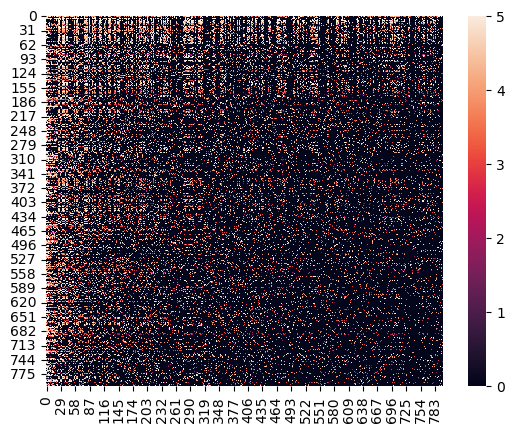

In [153]:
sns.heatmap(matrix_small)

In [154]:
matrix_small[matrix_small > 0].astype(bool).sum()

np.int64(113033)

### Generate validation set

In [155]:
def generate_val_set(y, size=0.1, seed=42, only_observed=True):
    np.random.seed(seed)
    n_users, n_items = y.shape
    n_val = int(size*n_users*n_items)
    y_val = []
    for _ in range(n_val):
        u = np.random.randint(n_users)
        i = np.random.randint(n_items)
        if only_observed:
            while y[u,i] == 0:
                u = np.random.randint(n_users)
                i = np.random.randint(n_items)
        y_val.append((u,i, int(y[u,i])))
    
    y_train = y.copy()
    for u,i, _ in y_val:
        y_train[u,i] = 0
    
    return y_train, y_val

In [190]:
import numpy as np
from scipy.special import gammaln, comb

def expected_cl_py(n, sigma, theta, H):
    n = int(n)
    if not (0 <= sigma < 1 and theta > -sigma and n > 0 and H > 1):
        raise ValueError("Invalid input: ensure 0 <= sigma < 1, theta > -sigma, n > 0, H > 1")

    if np.isinf(H):
        if sigma == 0:
            out = theta * np.sum(1 / (theta - 1 + np.arange(1, n + 1)))
        else:
            out = (1 / sigma) * np.exp(
                gammaln(theta + sigma + n) - gammaln(theta + sigma) -
                gammaln(theta + n) + gammaln(theta + 1)
            ) - theta / sigma
    else:
        if sigma == 0:
            index = np.arange(n)
            out = H - H * np.exp(np.sum(
                np.log(index + theta * (1 - 1/H)) - np.log(theta + index)
            ))
        else:
            raise NotImplementedError("Case with finite H and sigma > 0 is not implemented in the original R function.")
    
    return out

def HGnedin(V, h, gamma=0.5):
    return np.exp(
        gammaln(V + 1) - gammaln(h + 1) - gammaln(V - h + 1)
        + gammaln(h - gamma) - gammaln(1 - gamma)
        + np.log(gamma)
        + gammaln(V + gamma - h) - gammaln(V + gamma)
    )

# Example usage
V = 1000
gamma = 0.55
h = np.arange(1, V + 1)  # equivalent to 1:V in R

probs_gnedin = HGnedin(V, h, gamma=gamma)
result = round(np.sum(h * probs_gnedin))

expected_cl_py(1000, 0, 200, np.inf)


np.float64(358.76896560382943)

In [157]:
Y_train, y_val = generate_val_set(matrix_small, size=0.2, seed=42, only_observed=False)

In [158]:
y_test = y_val[:int(0.2*len(y_val))]
y_val = y_val[int(0.2*len(y_val)):]

In [159]:
# np.save('Y_train_books.npy', Y_train)
# np.save('y_val_books.npy', y_val)

In [160]:
Y_train.shape

(800, 800)

In [161]:
Y_val_pairs = [(u,i) for u,i,_ in y_val]
Y_val_users = [u for u,_,_ in y_val]
Y_val_items = [i for _,i,_ in y_val]
Y_val_ratings = [r for _,_,r in y_val]

val_users_relevant = {}
val_users_unique = np.unique(Y_val_users)
model_list_out = []

for u, i in Y_val_pairs:
    if u not in val_users_relevant:
        val_users_relevant[u] = []
    val_users_relevant[u].append(i)

Y_test_pairs = [(u,i) for u,i,_ in y_test]
Y_test_users = [u for u,_,_ in y_test]
Y_test_items = [i for _,i,_ in y_test]
Y_test_ratings = [r for _,_,r in y_test]

test_users_relevant = {}
test_users_unique = np.unique(Y_test_users)
model_list_out = []

for u, i in Y_test_pairs:
    if u not in test_users_relevant:
        test_users_relevant[u] = []
    test_users_relevant[u].append(i)
    

In [162]:
def validate_models(Y_train, Y_val, model_list, param_list, n_iters=500, burn_in=None, verbose=0,
                    thinning=3, model_names=None, true_users=None, true_items=None, k=None, print_intermid=False):
    if burn_in is None:
        burn_in = n_iters//2
    
    Y_val_pairs = [(u,i) for u,i,_ in Y_val]
    Y_val_users = [u for u,_,_ in Y_val]
    Y_val_items = [i for _,i,_ in Y_val]
    Y_val_ratings = [r for _,_,r in Y_val]
    
    val_users_relevant = {}
    val_users_unique = np.unique(Y_val_users)
    model_list_out = []

    for u, i in Y_val_pairs:
        if u not in val_users_relevant:
            val_users_relevant[u] = []
        val_users_relevant[u].append(i)
        
    for i in range(len(model_list)):
        if model_names is not None:
            name = model_names[i]
        else:
            name = i
            
        print('\nModel name:', name)
            
        model_type = model_list[i]
        params = param_list[i]
        model = model_type(Y=Y_train, num_users=Y_train.shape[0], num_items=Y_train.shape[1], **params)
        print('Starting training for model', name)
        llk_model, user_cl_model, item_cl_model = model.gibbs_train(n_iters, verbose=verbose)
        model_est_users, model_est_items, model_vi_users, model_vi_items = model.estimate_cluster_assignment_vi(burn_in=burn_in, thinning=thinning)
        
        waic_model = None
        
        
        print('Starting waic computation', name)        
        llk_edges = []
        # for iter in range(burn_in, model.n_iters, thinning):
        #     llk_edges.append(model.compute_llk(iter))
        # waic_model = waic_calculation(np.array(llk_edges))
        
        print('Starting prediction for model', name)
        model_ratings = model.point_predict(Y_val_pairs, seed=42)
        mae_model = mean_absolute_error(Y_val_ratings, model_ratings)
        mse_model = mean_squared_error(Y_val_ratings, model_ratings)    
        if print_intermid is True:
            print(f'MSE {name}: {mse_model}')
            print(f'MAE {name}: {mae_model}')
            
        
        print('Starting ranking for model', name)
        if k is None:
            ranks_model = model.predict_with_ranking(val_users_unique)
        else:
            ranks_model = model.predict_k(val_users_unique, k=k)
            
        precision_list_model = []   
        recall_list_model = []
        for j in range(len(val_users_unique)):
            precision_list_model.append(compute_precision(val_users_relevant[val_users_unique[j]], ranks_model[j]))
            recall_list_model.append(compute_recall(val_users_relevant[val_users_unique[j]], ranks_model[j]))
        precision_model = sum(precision_list_model)/len(precision_list_model)
        recall_model = sum(recall_list_model)/len(recall_list_model)
        if print_intermid is True:
            print(f'precision {name}: {precision_model}')
            print(f'recall {name}: {recall_model}')
        
        if true_users is not None:
            vi_users_model = VI(true_users, model.user_clustering)[0]
            model.vi_users = vi_users_model
            if print_intermid is True:
                print(f'VI users {name}: {vi_users_model}')

        if true_items is not None:
            vi_items_model = VI(true_items, model.item_clustering)[0]
            model.vi_items = vi_items_model
            if print_intermid is True:
                print(f'VI items {name}: {vi_items_model}')
        
        model.precision_ranks = precision_model
        model.recall_ranks = recall_model
        model.mae = mae_model
        model.mse = mse_model
        model.waic = waic_model
        model.llk_edges = llk_edges
        
        model_list_out.append(model)
        
    return model_list_out

## Degree-corrected models

In [163]:
burn_in = 0
thinning = 1
n_iters = 10
k = 10

In [164]:
params_baseline = {'scheme_type':'DP', 'cov_users':None,'cov_items':None, 'prior_a':1, 
                   'prior_b':1, 'seed':2, 'bar_h_users':2, 'bar_h_items':3,
                   'gamma':0.1, 'epsilon':1e-10, 'sigma':0.7, 'alpha_c':[1.5, 1.5, 1.5, 1.5], 
                   'user_clustering':'random', 'item_clustering':'random'}



params_py = params_baseline.copy()
params_py['prior_a'] = 1
params_py['prior_b'] = 1
params_py['degree_param_users'] = 1
params_py['degree_param_items'] = 1
params_py['scheme_param'] = 2
params_py['sigma'] = 0.1 # gives me expected value ~10 for items and ~13 for users
params_py['scheme_type'] = 'DP'

params_gn = params_baseline.copy()
params_gn['prior_a'] = 1
params_gn['prior_b'] = 1
params_gn['degree_param_users'] = 100
params_gn['degree_param_items'] = 100
params_gn['gamma'] = 0.55 # expected value ~10 for items and ~20 for users
params_gn['scheme_param'] = 2
params_gn['scheme_type'] = 'DP'

params_esbm = params_baseline.copy()
params_esbm['prior_a'] = 1
params_esbm['prior_b'] = 1
params_esbm['scheme_param'] = 2
params_esbm['scheme_type'] = 'DP'


In [165]:
params_dp = params_baseline.copy()

params_dp['prior_a'] = 1
params_dp['prior_b'] = 1
params_dp['degree_param_users'] = 1
params_dp['degree_param_items'] = 1
params_dp['scheme_param'] = 2 # gives me expected value ~10 for items and ~13 for users
params_dp['scheme_type'] = 'DP'
params_dp['seed'] = 42

params_dp2 = params_dp.copy()
params_dp2['degree_param_users'] = 10
params_dp2['degree_param_items'] = 10

params_dp3 = params_dp.copy()
params_dp3['degree_param_users'] = 10000
params_dp3['degree_param_items'] = 10000


model_list = [dcesbm, dcesbm, dcesbm]
params_list = [params_dp, params_dp2, params_dp3]
model_names = ['DP', 'DP2', 'DP3']

In [166]:
ut_models_dc = validate_models(Y_train, y_val, model_list, params_list, n_iters=800, 
                                burn_in=0, k = k,verbose=1, thinning=1, model_names=model_names, 
                                print_intermid=True)


Model name: DP
initialsing user clusters random
initialising item clusters random
Starting training for model DP
starting log likelihood -505144.6532216661
0 -415257.26864988083
time 0.6800594329833984
80 -247961.03741175632
time 906.1989848613739
160 -247889.42157498607
time 861.4220340251923
240 -247790.8421998481
time 1059.406170129776
320 -247795.29350975677
time 5700.118695735931
400 -247775.40017543364
time 1202.2101745605469
480 -247000.32911644204
time 1270.7345452308655
560 -246999.92649062016
time 1186.5239696502686
640 -246997.06366186807
time 1120.7545790672302
720 -246990.99011010188
time 1113.6888661384583
end llk:  -246989.6520927494
Starting waic computation DP
Starting prediction for model DP
MSE DP: 1.845173942903219
MAE DP: 0.7985522605332674
Starting ranking for model DP
precision DP: 0.3765
recall DP: 0.029424252124939505

Model name: DP2
initialsing user clusters random
initialising item clusters random
Starting training for model DP2
starting log likelihood -504

In [167]:
model_dp = ut_models_dc[0]
model_dp2 = ut_models_dc[1]
model_dp3 = ut_models_dc[2]

#model_py = out_models_dc[1]
#model_gn = out_models_dc[2]
#model_esbm = out_models_dc[3]

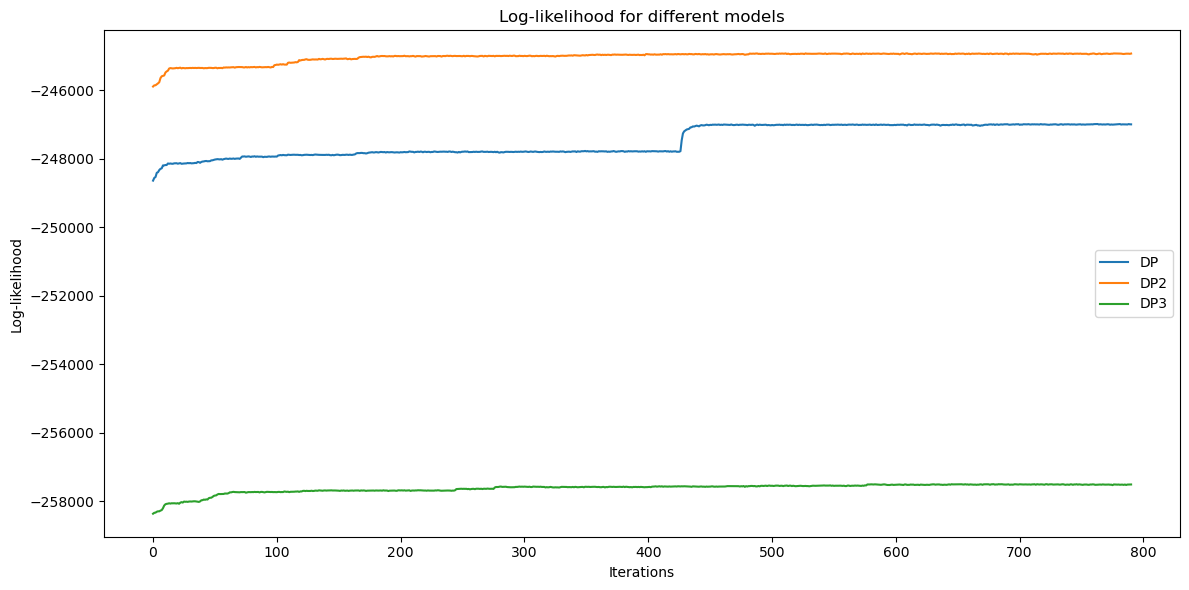

In [168]:
llk_dp = model_dp.train_llk
llk_dp2 = model_dp2.train_llk
llk_dp3 = model_dp3.train_llk


# llk_py = model_py.train_llk
# llk_gn = model_gn.train_llk
# llk_esbm = model_esbm.train_llk

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(llk_dp[10::], label='DP')
ax.plot(llk_dp2[10::], label='DP2')
ax.plot(llk_dp3[10::], label='DP3')

# ax.plot(llk_py[2::2], label='PY')
# ax.plot(llk_gn[2::2], label='GN')
# ax.plot(llk_esbm[2::2], label='ESBM')
ax.legend()


plt.title('Log-likelihood for different models')
plt.xlabel('Iterations')
plt.ylabel('Log-likelihood')

plt.tight_layout()
plt.show()

In [169]:
mae_dp = model_dp.mae
mae_dp2 = model_dp3.mae
mae_dp3 = model_dp2.mae


# mae_py = model_py.mae
# mae_gn = model_gn.mae
# mae_esbm = model_esbm.mae

mse_dp = model_dp.mse
mse_dp2 = model_dp2.mse
mse_dp3 = model_dp3.mse


# mse_py = model_py.mse
# mse_gn = model_gn.mse
# mse_esbm = model_esbm.mse

waic_dp = model_dp.waic
# waic_py = model_py.waic
# waic_gn = model_gn.waic
# waic_esbm = model_esbm.waic

precision_dp = model_dp.precision_ranks
precision_dp2 = model_dp2.precision_ranks
precision_dp3 = model_dp3.precision_ranks


# precision_py = model_py.precision_ranks
# precision_gn = model_gn.precision_ranks
# precision_esbm = model_esbm.precision_ranks

recall_dp = model_dp.recall_ranks
recall_dp2 = model_dp2.recall_ranks
recall_dp3 = model_dp3.recall_ranks

# recall_py = model_py.recall_ranks
# recall_gn = model_gn.recall_ranks
# recall_esbm = model_esbm.recall_ranks

In [170]:
output_table = pd.DataFrame()
output_table['MAE'] = [mae_dp, mae_dp2, mae_dp3]
output_table['MSE'] = [mse_dp, mse_dp2, mse_dp3]
output_table['Precision'] = [precision_dp, precision_dp2, precision_dp3]
output_table['Recall'] = [recall_dp, recall_dp2, recall_dp3]
output_table.index = ['DP', 'DP2', 'DP3']
output_table

,MAE,MSE,Precision,Recall
DP,0.798552,1.845174,0.376500,0.029424
DP2,0.812499,1.813714,0.384250,0.029989
DP3,0.789788,1.869683,0.383125,0.030017


In [171]:
model_dp.n_clusters_items, model_dp.n_clusters_users, model_dp2.n_clusters_items, model_dp2.n_clusters_users, model_dp3.n_clusters_items, model_dp3.n_clusters_users, 

(100, 100, 100, 100, 100, 100)

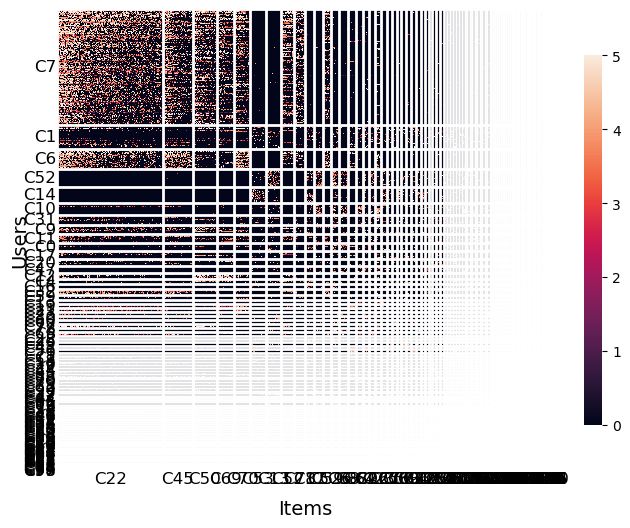

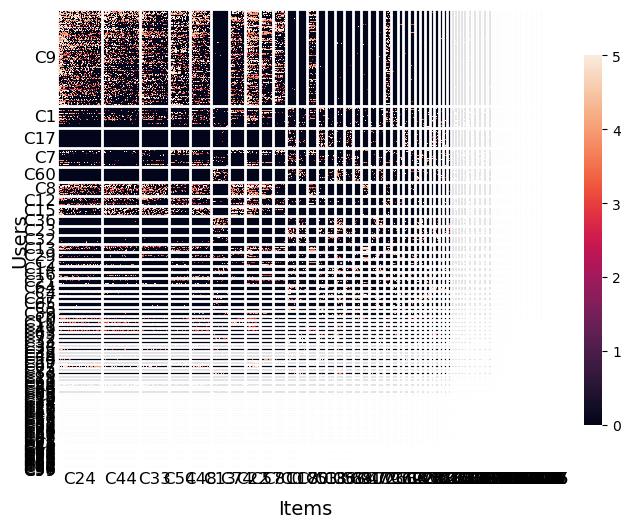

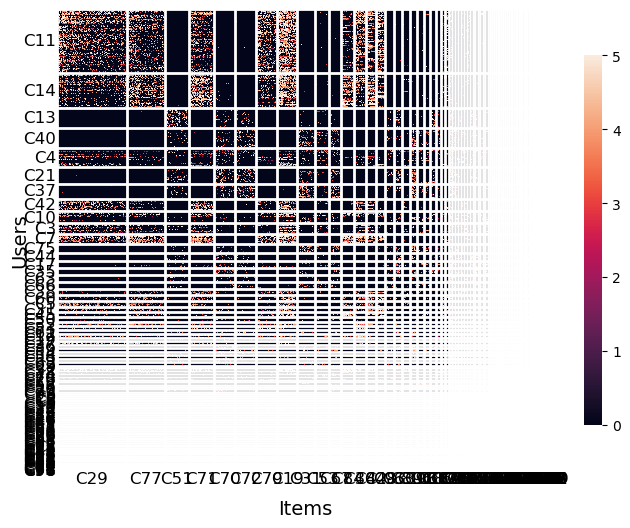

(None, None, None)

In [172]:
plot_heatmap(model_dp, size=(8,6)), plot_heatmap(model_dp2, size=(8,6)), plot_heatmap(model_dp3, size=(8,6))

In [173]:
1/0

ZeroDivisionError: division by zero

In [ ]:
Y_val = y_val

Y_val_pairs = [(u,i) for u,i,_ in Y_val]
Y_val_users = [u for u,_,_ in Y_val]
Y_val_items = [i for _,i,_ in Y_val]
Y_val_ratings = [r for _,_,r in Y_val]

val_users_relevant = {}
val_users_unique = np.unique(Y_val_users)
model_list_out = []

for u, i in Y_val_pairs:
    if u not in val_users_relevant:
        val_users_relevant[u] = []
    val_users_relevant[u].append(i)

In [ ]:
model_dp.degree_param_users = 100
model_dp.degree_param_items = 100
model_dp.estimate_phi()
_ = model_dp.estimate_theta()

In [ ]:
model_dp.estimate_cluster_assignment_vi(burn_in=100, thinning=thinning)

model_ratings = model_dp.point_predict(Y_val_pairs, seed=42)
mae_model = mean_absolute_error(Y_val_ratings, model_ratings)
mse_model = mean_squared_error(Y_val_ratings, model_ratings)   

print('MAE:', mae_model)
print('MSE:', mse_model) 

ranks_model = model_dp.predict_k(val_users_unique, k=k)
    
precision_list_model = []   
recall_list_model = []
for j in range(len(val_users_unique)):
    precision_list_model.append(compute_precision(val_users_relevant[val_users_unique[j]], ranks_model[j]))
    recall_list_model.append(compute_recall(val_users_relevant[val_users_unique[j]], ranks_model[j]))
precision_model = sum(precision_list_model)/len(precision_list_model)
recall_model = sum(recall_list_model)/len(recall_list_model)
print('Precision:', precision_model)
print('Recall:', recall_model)

[ 5 18 10 11  5 47 10  5 10 10 10 13  5  4  9  5  2  5  5  5  1  1  2  1
  1] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]] 1 102
[ 5 18 10 11  5 47 10  5 10 10 10 13  5  4  9  5  2  5  5  5  1  1  2  1
  1] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]] 17 92
[ 5 18 10 11  5 47 10  5 10 10 10 13  5  4  9  5  2  5  5  5  1  1  2  1
  1] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]] 17 106
[ 5 18 10 11  5 47 10  5 10 10 10 13  5  4  9  5  2  5  5  5  1  1  2  1
  1] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]] 1 188
[ 5 18 10 11  5 47 10  5 10 10 10 13  5

(array([3.98e+03, 0.00e+00, 5.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
        2.00e+00, 2.00e+00, 0.00e+00, 2.00e+00, 4.00e+00, 2.00e+00]),
 array([ 0.        ,  1.40790359,  2.81580717,  4.22371076,  5.63161435,
         7.03951793,  8.44742152,  9.8553251 , 11.26322869, 12.67113228,
        14.07903586, 15.48693945, 16.89484304, 18.30274662, 19.71065021,
        21.1185538 , 22.52645738, 23.93436097, 25.34226456, 26.75016814,
        28.15807173, 29.56597531, 30.9738789 , 32.38178249, 33.78968607,
        35.19758966, 36.60549325, 38.01339683, 39.42130042, 40.82920401,
        42.23710759]),
 <BarContainer object of 30 artists>)

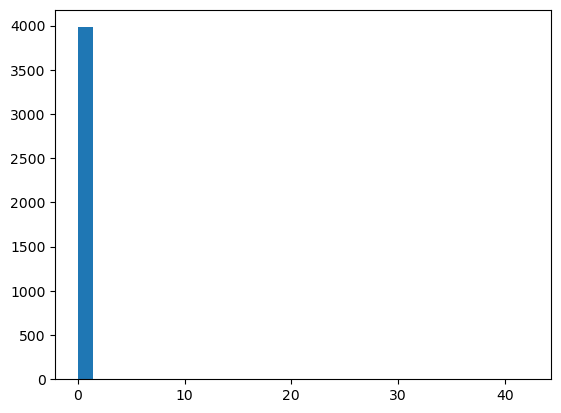

In [ ]:
plt.hist(model_ratings, bins=30)

In [ ]:
np.unique(np.round(model_ratings), return_counts=True)

(array([ 0.,  3.,  4., 31., 32., 33., 34., 36., 39., 40., 41., 42.]),
 array([3980,    3,    2,    1,    1,    1,    2,    2,    2,    4,    1,
           1]))

## Non dc model

In [ ]:
burn_in = 1000
thinning = 5
n_iters = 2000
k = 10

In [ ]:
params_baseline = {'cov_users':None,'cov_items':None, 'prior_a':1, 'prior_b':1, 'seed':42, 'scheme_param':1, 'bar_h_users':2, 'bar_h_items':3,
           'gamma':0.1, 'epsilon':1e-30, 'sigma':0.7, 'alpha_c':[1.5, 1.5, 1.5, 1.5]}

params_dp = params_baseline.copy()

params_dp['prior_a'] = 1
params_dp['prior_b'] = 1
params_dp['scheme_param'] = 0.5
params_dp['sigma'] = 0.5
params_dp['scheme_type'] = 'DP'


params_py = params_baseline.copy()
params_py['prior_a'] = 1
params_py['prior_b'] = 1
params_py['scheme_param'] = 1
params_py['sigma'] = 0.7
params_py['scheme_type'] = 'PY'

params_gn = params_baseline.copy()
params_gn['prior_a'] = 1
params_gn['prior_b'] = 1
params_gn['gamma'] = 0.9
params_gn['scheme_type'] = 'GN'

params_dp_cov = params_baseline.copy()
params_dp_cov['prior_a'] = 1
params_dp_cov['prior_b'] = 1
params_dp_cov['scheme_param'] = 0.5
params_dp_cov['cov_users'] = cov_users
params_dp_cov['cov_items'] = cov_items
params_dp_cov['scheme_type'] = 'DP'

params_gn_cov = params_baseline.copy()
params_gn_cov['prior_a'] = 1
params_gn_cov['prior_b'] = 1
params_gn_cov['gamma'] = 0.3
params_gn_cov['cov_users'] = cov_users
params_gn_cov['cov_items'] = cov_items
params_gn_cov['scheme_type'] = 'GN'

params_py_cov = params_baseline.copy()
params_py_cov['prior_a'] = 1
params_py_cov['prior_b'] = 1
params_py_cov['sigma'] = 0.7
params_py_cov['scheme_param'] = 0.5
params_py_cov['cov_users'] = cov_users
params_py_cov['cov_items'] = cov_items
params_py_cov['scheme_type'] = 'PY'

model_list = [esbm, esbm, esbm, esbm, esbm, esbm]
params_list = [params_dp, params_py, params_gn, params_dp_cov, params_py_cov, params_gn_cov]
model_names = ['DP', 'PY', 'GN', 'DP_cov', 'PY_cov', 'GN_cov']

In [ ]:
out_models = validate_models(Y_train, Y_val, model_list, params_list, n_iters=n_iters, burn_in=burn_in, k = k,
                                 thinning=thinning, model_names=model_names, true_users=true_users, true_items=true_items)


Model name: DP
Starting training for model DP
starting log likelihood -34232.09429665616
end llk:  -23781.1248436591
Starting waic computation DP
Starting prediction for model DP
Starting ranking for model DP

Model name: PY
Starting training for model PY
starting log likelihood -34232.09429665616
end llk:  -23826.251274828264
Starting waic computation PY
Starting prediction for model PY
Starting ranking for model PY

Model name: GN
Starting training for model GN
starting log likelihood -34232.09429665616
end llk:  -23839.11167367239
Starting waic computation GN
Starting prediction for model GN
Starting ranking for model GN

Model name: DP_cov
Starting training for model DP_cov
starting log likelihood -34232.09429665616
end llk:  -23820.938562184234
Starting waic computation DP_cov
Starting prediction for model DP_cov
Starting ranking for model DP_cov

Model name: PY_cov
Starting training for model PY_cov
starting log likelihood -34232.09429665616
end llk:  -23823.368440979342
Startin

In [ ]:
model_dp = out_models[0]
model_py = out_models[1]
model_gn = out_models[2]
model_dp_cov = out_models[3]
model_py_cov = out_models[4]
model_gn_cov = out_models[5]

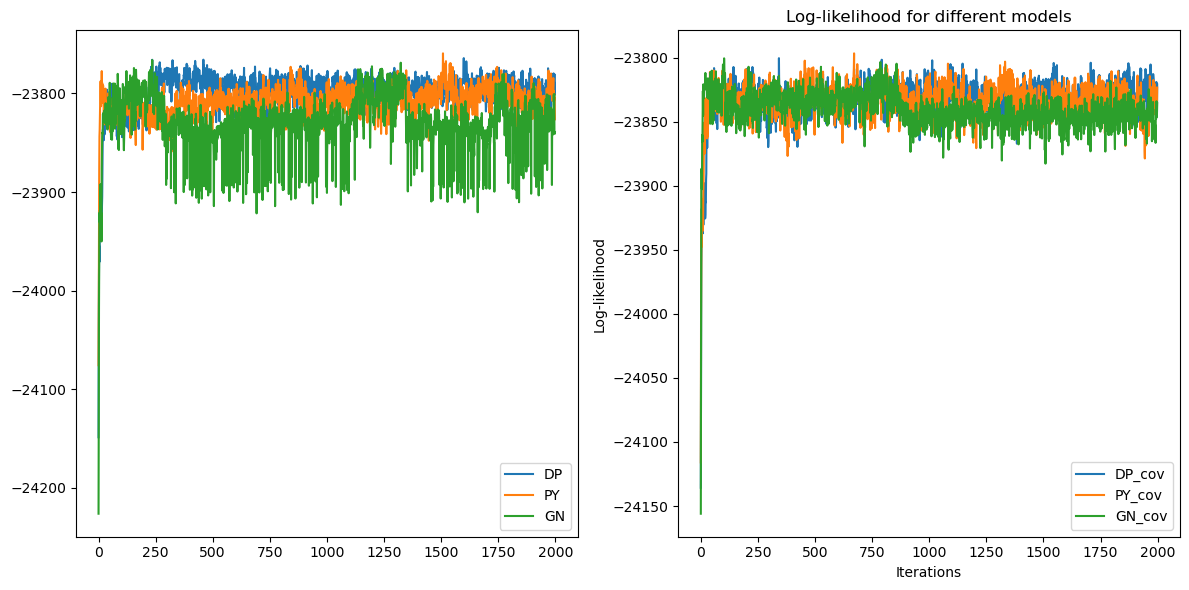

In [ ]:
llk_dp = out_models[0].train_llk
llk_py = out_models[1].train_llk
llk_gn = out_models[2].train_llk

llk_dp_cov = out_models[3].train_llk
llk_py_cov = out_models[4].train_llk
llk_gn_cov = out_models[5].train_llk

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(llk_dp[2:], label='DP')
ax[0].plot(llk_py[2:], label='PY')
ax[0].plot(llk_gn[2:], label='GN')
ax[0].legend()

ax[1].plot(llk_dp_cov[2:], label='DP_cov')
ax[1].plot(llk_py_cov[2:], label='PY_cov')
ax[1].plot(llk_gn_cov[2:], label='GN_cov')
ax[1].legend()

plt.title('Log-likelihood for different models')
plt.xlabel('Iterations')
plt.ylabel('Log-likelihood')

plt.tight_layout()
plt.show()

In [ ]:
vi_users_dp = model_dp.vi_users
vi_items_dp = model_dp.vi_items
vi_users_py = model_py.vi_users
vi_items_py = model_py.vi_items
vi_users_gn = model_gn.vi_users
vi_items_gn = model_gn.vi_items

vi_users_dp_cov = model_dp_cov.vi_users
vi_items_dp_cov = model_dp_cov.vi_items
vi_users_py_cov = model_py_cov.vi_users
vi_items_py_cov = model_py_cov.vi_items
vi_users_gn_cov = model_gn_cov.vi_users
vi_items_gn_cov = model_gn_cov.vi_items

mae_dp = model_dp.mae
mae_py = model_py.mae
mae_gn = model_gn.mae

mae_dp_cov = model_dp_cov.mae
mae_py_cov = model_py_cov.mae
mae_gn_cov = model_gn_cov.mae

mse_dp = model_dp.mse
mse_py = model_py.mse
mse_gn = model_gn.mse

mse_dp_cov = model_dp_cov.mse
mse_py_cov = model_py_cov.mse
mse_gn_cov = model_gn_cov.mse

waic_dp = model_dp.waic
waic_py = model_py.waic
waic_gn = model_gn.waic

waic_dp_cov = model_dp_cov.waic
waic_py_cov = model_py_cov.waic
waic_gn_cov = model_gn_cov.waic

precision_dp = model_dp.precision_ranks
precision_py = model_py.precision_ranks
precision_gn = model_gn.precision_ranks

precision_dp_cov = model_dp_cov.precision_ranks
precision_py_cov = model_py_cov.precision_ranks
precision_gn_cov = model_gn_cov.precision_ranks

recall_dp = model_dp.recall_ranks
recall_py = model_py.recall_ranks
recall_gn = model_gn.recall_ranks

recall_dp_cov = model_dp_cov.recall_ranks
recall_py_cov = model_py_cov.recall_ranks
recall_gn_cov = model_gn_cov.recall_ranks

In [ ]:
output_table2 = pd.DataFrame()

output_table2['VI users'] = [vi_users_dp, vi_users_py, vi_users_gn, vi_users_dp_cov, vi_users_py_cov, vi_users_gn_cov]
output_table2['VI items'] = [vi_items_dp, vi_items_py, vi_items_gn, vi_items_dp_cov, vi_items_py_cov, vi_items_gn_cov]
output_table2['MAE'] = [mae_dp, mae_py, mae_gn, mae_dp_cov, mae_py_cov, mae_gn_cov]
output_table2['MSE'] = [mse_dp, mse_py, mse_gn, mse_dp_cov, mse_py_cov, mse_gn_cov]
output_table2['WAIC'] = [waic_dp, waic_py, waic_gn, waic_dp_cov, waic_py_cov, waic_gn_cov]
output_table2['Precision'] = [precision_dp, precision_py, precision_gn, precision_dp_cov, precision_py_cov, precision_gn_cov]
output_table2['Recall'] = [recall_dp, recall_py, recall_gn, recall_dp_cov, recall_py_cov, recall_gn_cov]

output_table2.index = ['DP', 'PY', 'GN', 'DP_cov', 'PY_cov', 'GN_cov']
output_table2

In [ ]:
output_table2 = pd.DataFrame()

output_table2['VI users'] = [vi_users_dp, vi_users_py, vi_users_gn, vi_users_dp_cov, vi_users_py_cov, vi_users_gn_cov]
output_table2['VI items'] = [vi_items_dp, vi_items_py, vi_items_gn, vi_items_dp_cov, vi_items_py_cov, vi_items_gn_cov]
output_table2['MAE'] = [mae_dp, mae_py, mae_gn, mae_dp_cov, mae_py_cov, mae_gn_cov]
output_table2['MSE'] = [mse_dp, mse_py, mse_gn, mse_dp_cov, mse_py_cov, mse_gn_cov]
output_table2['WAIC'] = [waic_dp, waic_py, waic_gn, waic_dp_cov, waic_py_cov, waic_gn_cov]
output_table2['Precision'] = [precision_dp, precision_py, precision_gn, precision_dp_cov, precision_py_cov, precision_gn_cov]
output_table2['Recall'] = [recall_dp, recall_py, recall_gn, recall_dp_cov, recall_py_cov, recall_gn_cov]

output_table2.index = ['DP', 'PY', 'GN', 'DP_cov', 'PY_cov', 'GN_cov']
output_table2.round(4)

,VI users,VI items,MAE,MSE,WAIC,Precision,Recall
DP,1.5272,1.3090,0.4830,0.5483,3244.6705,0.4420,0.1110
PY,1.5556,1.3747,0.4825,0.5467,3167.1810,0.4440,0.1118
GN,1.3281,1.2508,0.4799,0.5450,3139.7548,0.4360,0.1100
DP_cov,1.2870,1.2180,0.4795,0.5455,3126.0909,0.4395,0.1106
PY_cov,1.3130,1.2282,0.4823,0.5492,3093.5000,0.4415,0.1108
GN_cov,1.2722,1.2031,0.4799,0.5442,3115.9858,0.4460,0.1126


In [ ]:
output_table.round(4)

,VI users,VI items,MAE,MSE,WAIC,Precision,Recall
DP,0.1885,0.0000,0.4720,0.5295,3456.0706,0.4440,0.1115
PY,0.3635,0.0752,0.4736,0.5308,3372.7282,0.4400,0.1106
GN,0.1686,0.0752,0.4748,0.5310,3419.8139,0.4445,0.1116
DP_cov,0.0652,0.0000,0.4752,0.5315,3334.8288,0.4435,0.1114
PY_cov,0.0652,0.0000,0.4724,0.5294,3425.9722,0.4445,0.1116
GN_cov,0.2844,0.0000,0.4745,0.5319,3339.8332,0.4435,0.1114


from the next cell it is clear that the issue of flat esbm is that it tends to cluster based on degree 

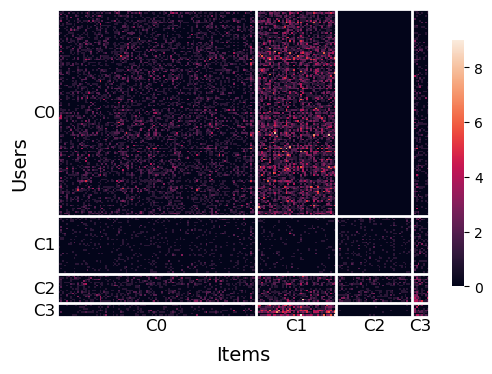

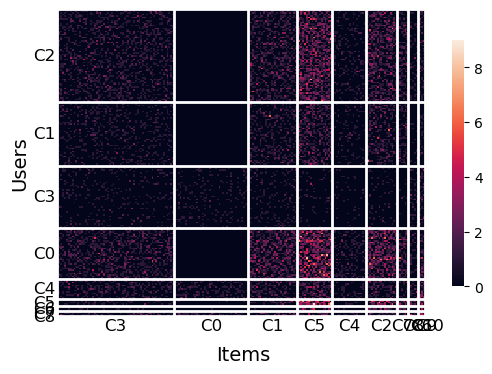

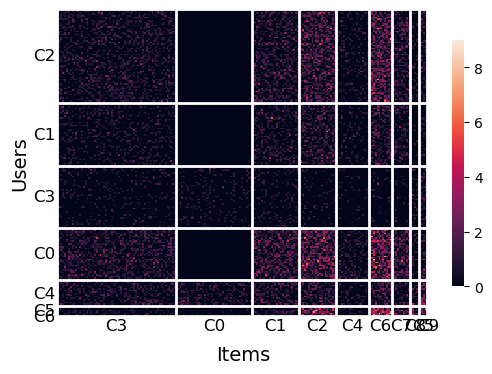

(None, None, None)

In [ ]:
plot_heatmap(model, size=(6,4)), plot_heatmap(model_py_cov, size=(6,4)), plot_heatmap(model_gn_cov, size=(6,4))

## other methods

In [ ]:
from sklearn.cluster import SpectralBiclustering, SpectralCoclustering
from sklearn.model_selection import GridSearchCV

spectral_bi = SpectralBiclustering(n_clusters=(5, 5), method='log', n_components=40, n_best=40)
spectral_bi.fit(Y_train)

SpectralBiclustering(method='log', n_best=40, n_clusters=(5, 5),
                     n_components=40)

In [ ]:
VI(model.user_clustering, relabel_clusters(spectral_bi.row_labels_)), VI(model.item_clustering, relabel_clusters(spectral_bi.column_labels_)) 

(array([1.73794648]), array([1.84691007]))

# past results

params_baseline = {'cov_users':None,'cov_items':None, 'prior_a':1, 'prior_b':1, 'seed':42, 'scheme_param':1, 'bar_h_users':2, 'bar_h_items':3,
           'gamma':0.1, 'epsilon':1e-30, 'sigma':0.7, 'alpha_c':[1.5, 1.5, 1.5, 1.5]}

params_dp = params_baseline.copy()

params_dp['prior_a'] = 1
params_dp['prior_b'] = 3.5
params_dp['degree_param_users'] = 2
params_dp['degree_param_items'] = 4
params_dp['scheme_param'] = 0.135
params_dp['sigma'] = 0.329
params_dp['scheme_type'] = 'DP'

params_py = params_baseline.copy()
params_py['prior_a'] = 1
params_py['prior_b'] = 3.5
params_py['degree_param_users'] = 1
params_py['degree_param_items'] = 15
params_py['scheme_param'] = 1.9
params_py['sigma'] = 0.7
params_py['scheme_type'] = 'PY'

params_gn = params_baseline.copy()
params_gn['prior_a'] = 1
params_gn['prior_b'] = 3.5
params_gn['degree_param_users'] = 15
params_gn['degree_param_items'] = 10
params_gn['gamma'] = 0.9
params_gn['scheme_type'] = 'GN'

params_dp_cov = params_baseline.copy()
params_dp_cov['prior_a'] = 0.7
params_dp_cov['prior_b'] = 3.5
params_dp_cov['degree_param_users'] = 16
params_dp_cov['degree_param_items'] = 11
params_dp_cov['scheme_param'] = 2
params_dp_cov['cov_users'] = cov_users
params_dp_cov['cov_items'] = cov_items
params_dp_cov['scheme_type'] = 'DP'

params_gn_cov = params_baseline.copy()
params_gn_cov['prior_a'] = 0.7
params_gn_cov['prior_b'] = 3.5
params_gn_cov['degree_param_users'] = 4
params_gn_cov['degree_param_items'] = 5
params_gn_cov['gamma'] = 0.3
params_gn_cov['cov_users'] = cov_users
params_gn_cov['cov_items'] = cov_items
params_gn_cov['scheme_type'] = 'GN'

params_py_cov = params_baseline.copy()
params_py_cov['prior_a'] = 0.7
params_py_cov['prior_b'] = 3.5
params_py_cov['degree_param_users'] = 4
params_py_cov['degree_param_items'] = 5
params_py_cov['sigma'] = 0.05
params_py_cov['scheme_param'] = 2
params_py_cov['cov_users'] = cov_users
params_py_cov['cov_items'] = cov_items
params_py_cov['scheme_type'] = 'PY'

model_list = [dcesbm, dcesbm, dcesbm, dcesbm, dcesbm, dcesbm]
params_list = [params_dp, params_py, params_gn, params_dp_cov, params_py_cov, params_gn_cov]
model_names = ['DP', 'PY', 'GN', 'DP_cov', 'PY_cov', 'GN_cov']

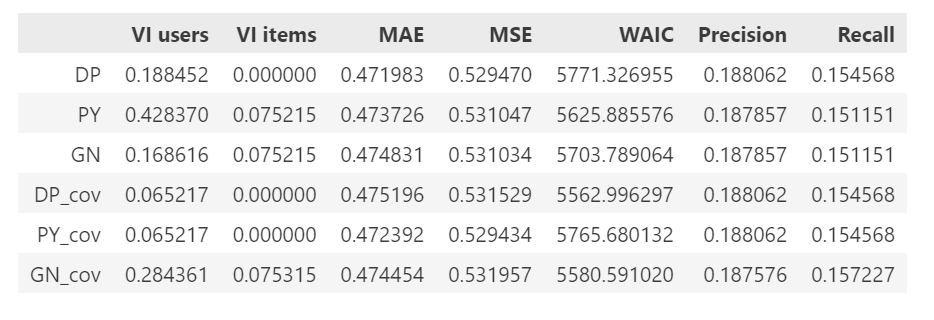
*data seed 1*

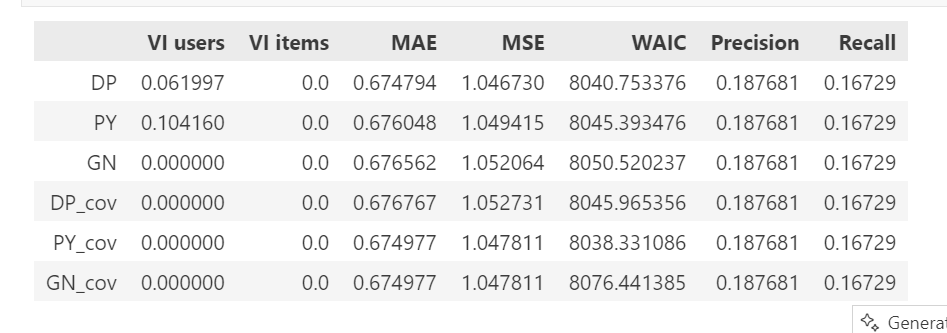
*data seed 42*